In [2]:
import os, sys
sys.path.append("../")
sys.path.append("../src/network")
sys.path.append("../src")
print(os.getcwd())

import torch
import string
import cv2
import numpy as np

from src.network.gen_model.gen_model import GenModel_FC
from src.data.data_loader import IAM_data
from src.data.reader import read_iam
from src.data.tokenizer import Tokenizer

import random
from random import choices

import matplotlib.pyplot as plt


c:\Users\Lisa\Documents\GitHub\handwriting-recognition\small_experiments


In [7]:
charset_base = string.ascii_lowercase + string.ascii_uppercase
max_text_length = 25
tokenizer = Tokenizer(chars=charset_base, max_text_length=max_text_length)

# Model Loading

### Generator

In [8]:
gen_model = GenModel_FC(tokenizer.maxlen, tokenizer.vocab_size, tokenizer.PAD).cuda()
gen_model.load_state_dict(torch.load('../src/network/gen_model/gen_model-2750-25ch-corr-half.model')) #load
gen_model.eval()

GenModel_FC(
  (enc_image): RecursiveScriptModule(
    original_name=ImageEncoder
    (model): RecursiveScriptModule(
      original_name=VGG
      (features): RecursiveScriptModule(
        original_name=Sequential
        (0): RecursiveScriptModule(original_name=Conv2d)
        (1): RecursiveScriptModule(original_name=InstanceNorm2d)
        (2): RecursiveScriptModule(original_name=ReLU)
        (3): RecursiveScriptModule(original_name=Conv2d)
        (4): RecursiveScriptModule(original_name=InstanceNorm2d)
        (5): RecursiveScriptModule(original_name=ReLU)
        (6): RecursiveScriptModule(original_name=Conv2d)
        (7): RecursiveScriptModule(original_name=InstanceNorm2d)
        (8): RecursiveScriptModule(original_name=ReLU)
        (9): RecursiveScriptModule(original_name=Conv2d)
        (10): RecursiveScriptModule(original_name=InstanceNorm2d)
        (11): RecursiveScriptModule(original_name=ReLU)
        (12): RecursiveScriptModule(original_name=MaxPool2d)
        (13):

# Data Loading

In [9]:
input_size = (64, 216, 1)
num_style_imgs = 25 # num imgs for generator to extract style from
batch_size = 32
dataset = "iam"
dataset_path = os.path.join("..", "data", dataset, "words")
max_word_len = 10

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [11]:
data_train, data_valid, data_test, _, _, _, wid_train, wid_valid, wid_test, _, _, _ = read_iam(dataset_path, max_word_len, synth=False)

train
number of words in train: 19744
number of wids in train: 500
Number of words per word length
2 4645
3 5617
4 4030
5 2404
6 1608
7 1440
valid
number of words in valid: 4105
number of wids in valid: 499
Number of words per word length
2 954
3 1135
4 806
5 513
6 373
7 324
test
number of words in test: 4357
number of wids in test: 500
Number of words per word length
2 978
3 1251
4 898
5 552
6 371
7 307
oov_train
number of words in oov_train: 1324
number of wids in oov_train: 306
Number of words per word length
2 13
3 76
4 257
5 334
6 358
7 286
oov_valid
number of words in oov_valid: 866
number of wids in oov_valid: 329
Number of words per word length
2 9
3 58
4 181
5 218
6 230
7 170
oov_test
number of words in oov_test: 1164
number of wids in oov_test: 352
Number of words per word length
2 12
3 63
4 223
5 293
6 320
7 253


In [12]:
data_train = IAM_data(data_train, input_size=input_size, tokenizer=tokenizer, num_images=num_style_imgs, wids=wid_train)
train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=1)

# Data Distributions

The mean and standard deviations between real and synthetic images were compared to see if they were substantially different.

In [ ]:
means_data = []
stds_data = []

means_synth = []
stds_synth = []

for batch in train_loader:
    imgs, gen_imgs, gt_labels, _ = batch
    gt_labels = torch.nn.functional.one_hot(gt_labels.long(), 56).float()

    imgs = imgs.to(device)
    gen_imgs = gen_imgs.to(device).squeeze(2)
    gt_labels = gt_labels.to(device)

    synth_imgs = gen_model(gen_imgs, gt_labels)

    means_data += torch.mean(imgs, dim=[2,3]).cpu().squeeze().numpy().tolist()
    means_synth += torch.mean(synth_imgs.detach(), dim=[2,3]).cpu().squeeze().numpy().tolist()

    stds_data += torch.std(imgs, dim=[2,3]).cpu().squeeze().numpy().tolist()
    stds_synth += torch.std(synth_imgs.detach(), dim=[2,3]).cpu().squeeze().numpy().tolist()
    
    

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


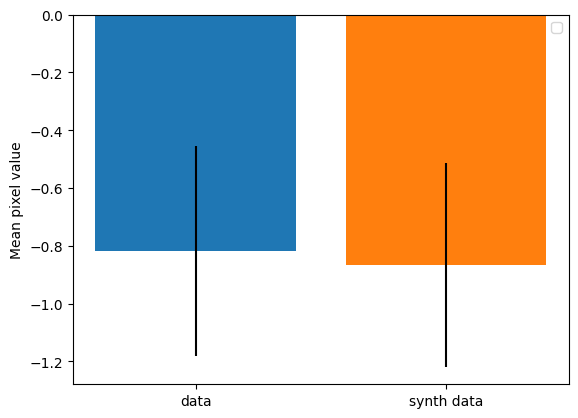

In [14]:
plt.bar(['Data'], np.mean(means_data), yerr=np.mean(stds_data))
plt.bar(['Synth data'], np.mean(means_synth), yerr=np.mean(stds_synth))
plt.ylabel('Mean pixel value')
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


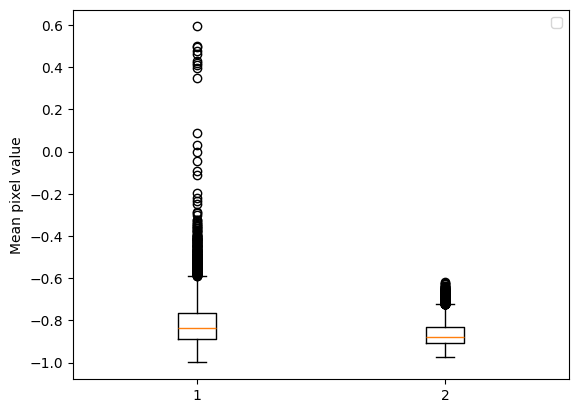

In [15]:
plt.boxplot([means_data,means_synth])
plt.ylabel('Mean pixel value')
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


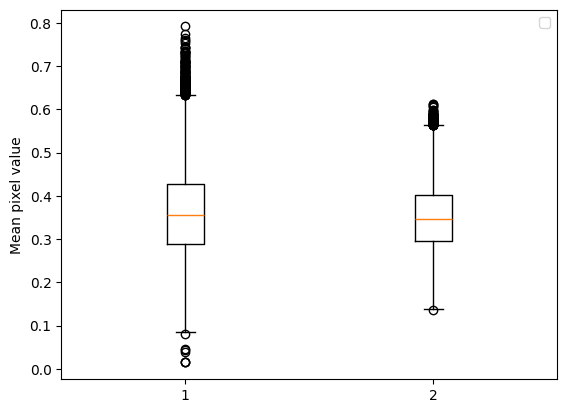

In [16]:
plt.boxplot([stds_data, stds_synth])
plt.ylabel('Mean pixel value')
# plt.xticks(labels=['data', 'synth data'])
plt.legend()
plt.show()

# Generate Example Image

written
Britain
as
sort
fellow
the
his
more
had
in
at
private
choke
Her
often
have
204 ..\data\iam\words\train\e06\e06-030\e06-030-02-02.png


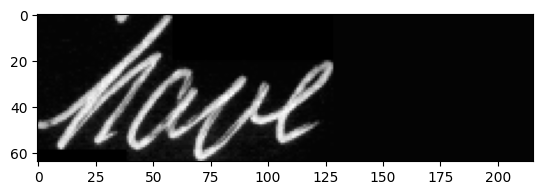

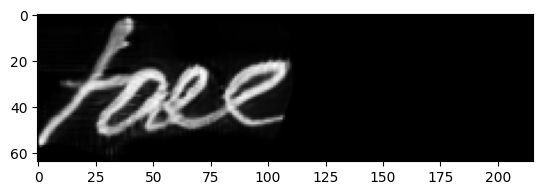

In [26]:
img_idx = np.random.randint(len(data_train.img_paths))
img, gen_input, gt_label, wid, _ = data_train.__getitem__(img_idx)

dec_lab = tokenizer.decode(gt_label)
while dec_lab != "have" :
    img_idx = np.random.randint(len(data_train.img_paths))
    img, gen_input, gt_label, wid, img_path = data_train.__getitem__(img_idx)

    dec_lab = tokenizer.decode(gt_label)
    print(dec_lab)

print(wid, img_path)
plt.imshow(img[0], cmap='gray')
plt.show()

label = torch.from_numpy(np.array(tokenizer.encode("taee"))).cuda().long()
label = torch.nn.functional.one_hot(label, 56).float()

gen_input = torch.from_numpy(gen_input).squeeze(1).unsqueeze(0).cuda()

synth_img = gen_model(gen_input, label.unsqueeze(0))
synth_img = synth_img.detach().cpu().numpy()

plt.imshow(synth_img[0][0], cmap='gray')
cv2.imwrite('./ex_img.png', 255 - (((synth_img[0][0] * 0.5) + 0.5) * 255))
plt.show()